In this notebook we are trying to predict the arrival delay of the flights using machine learning models such as linear regression, random Forest regressor and decision tree regressor

In [0]:
#Start SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

spark = (SparkSession
.builder
.appName("ML")
.getOrCreate()
)

In [0]:
#Importing Necessary Libraries
import pandas
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [0]:
flight_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/flights.csv"
flights = spark.read.csv(flight_file_path, header=True, inferSchema=True)

In [0]:
#Feature selection
data = flights.select('MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE','SCHEDULED_ARRIVAL','ARRIVAL_DELAY')
data.show()


+-----+---+-----------+-------+--------------+-------------------+--------+-----------------+-------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DISTANCE|SCHEDULED_ARRIVAL|ARRIVAL_DELAY|
+-----+---+-----------+-------+--------------+-------------------+--------+-----------------+-------------+
|    1|  1|          4|     AS|           ANC|                SEA|    1448|              430|          -22|
|    1|  1|          4|     AA|           LAX|                PBI|    2330|              750|           -9|
|    1|  1|          4|     US|           SFO|                CLT|    2296|              806|            5|
|    1|  1|          4|     AA|           LAX|                MIA|    2342|              805|           -9|
|    1|  1|          4|     AS|           SEA|                ANC|    1448|              320|          -21|
|    1|  1|          4|     DL|           SFO|                MSP|    1589|              602|            8|
|    1|  1|          4|     

In [0]:
#Setting the target Variable for prediction.

numericColumns = [
    'DISTANCE',
    'SCHEDULED_ARRIVAL'
]

target = ['ARRIVAL_DELAY']

categoricalColumns = [
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT'
]

In [0]:
data.select(numericColumns).describe().show()

+-------+-----------------+------------------+
|summary|         DISTANCE| SCHEDULED_ARRIVAL|
+-------+-----------------+------------------+
|  count|          5819079|           5819079|
|   mean|822.3564947305235|1493.8082485218022|
| stddev|607.7842873170453| 507.1646955936958|
|    min|               21|                 1|
|    max|             4983|              2400|
+-------+-----------------+------------------+



In [0]:
#Finding Correlation Between Distance and Scheduled_Arrival
numeric_data = data.select(numericColumns).toPandas()
numeric_data.corr()

,DISTANCE,SCHEDULED_ARRIVAL
DISTANCE,1.000000,0.027369
SCHEDULED_ARRIVAL,0.027369,1.000000


DISTANCE has a correlation of 1.000000 with itself and 0.027369 with SCHEDULED_ARRIVAL.
SCHEDULED_ARRIVAL has a correlation of 0.027369 with DISTANCE and 1.000000 with itself.
The correlation matrix indicates that there is a very weak positive correlation between DISTANCE and SCHEDULED_ARRIVAL, suggesting that the scheduled arrival time is almost independent of the flight distance. 

In [0]:
data.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)



In [0]:
from pyspark.ml.feature import  VectorAssembler,StandardScaler,StringIndexer, OneHotEncoder

In [0]:
# Define string indexer for each string column
indexer1 = StringIndexer(inputCol="ORIGIN_AIRPORT", outputCol="ORIGIN_AIRPORT_indx")
indexer2 = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="DESTINATION_AIRPORT_indx")
indexer3 = StringIndexer(inputCol="AIRLINE", outputCol="AIRLINE_indx")



In [0]:
# Define the VectorAssembler for numerical and encoded features
vector_assembler = VectorAssembler(inputCols=['MONTH','DAY','DAY_OF_WEEK','AIRLINE_indx','ORIGIN_AIRPORT_indx','DESTINATION_AIRPORT_indx','DISTANCE','SCHEDULED_ARRIVAL'], outputCol="features")



In [0]:
# Sample 30% of the data without replacement
sampled_data30 = data.sample(withReplacement=False, fraction=0.3)

# Sample 50% of the data without replacement
sampled_data50 = data.sample(withReplacement=False, fraction=0.5)

# Sample 70% of the data without replacement
sampled_data70 = data.sample(withReplacement=False, fraction=0.7)



In [0]:
# Create a Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2,indexer3, vector_assembler])

# Fit the pipeline to the DataFrame
pipeline_model = pipeline.fit(data)

In [0]:
# Transform the DataFrame
transformed_df = pipeline_model.transform(data)

# Show the transformed DataFrame
transformed_df.show()

In [0]:
ml_data = transformed_df.select('features','ARRIVAL_DELAY')

In [0]:
#handling missing data
ml_data = ml_data.fillna(0)

In [0]:
#Splitting the data 
train_df, test_df = ml_data.randomSplit([0.7,0.3],seed=42)

In [0]:

train_df.show()

+--------------------+-------------+
|            features|ARRIVAL_DELAY|
+--------------------+-------------+
|[1.0,1.0,4.0,0.0,...|           -8|
|[1.0,1.0,4.0,0.0,...|            7|
|[1.0,1.0,4.0,0.0,...|           17|
|[1.0,1.0,4.0,0.0,...|          -24|
|[1.0,1.0,4.0,0.0,...|          -25|
|[1.0,1.0,4.0,0.0,...|           -7|
|[1.0,1.0,4.0,0.0,...|          -11|
|[1.0,1.0,4.0,0.0,...|          -13|
|[1.0,1.0,4.0,0.0,...|           -5|
|[1.0,1.0,4.0,0.0,...|           34|
|[1.0,1.0,4.0,0.0,...|           -1|
|[1.0,1.0,4.0,0.0,...|           -7|
|[1.0,1.0,4.0,0.0,...|           17|
|[1.0,1.0,4.0,0.0,...|          -12|
|[1.0,1.0,4.0,0.0,...|           -3|
|[1.0,1.0,4.0,0.0,...|          -11|
|[1.0,1.0,4.0,0.0,...|          -26|
|[1.0,1.0,4.0,0.0,...|          -15|
|[1.0,1.0,4.0,0.0,...|          -12|
|[1.0,1.0,4.0,0.0,...|          -18|
+--------------------+-------------+
only showing top 20 rows



In [0]:
spark = (SparkSession
.builder
.appName("LinearRegressionTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='ARRIVAL_DELAY')

# Train the model
lr_model = lr.fit(train_df)


In [0]:
predictions = lr_model.transform(test_df)

In [0]:
spark = (SparkSession
.builder
.appName("LinearRegressionEval")
.getOrCreate()
)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using rmse, mae, r2
evaluator_rmse = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 38.46422666623374
Mean Absolute Error (MAE) on test data = 20.701735843127537
R-squared (R²) on test data = 0.011784485108977227


Root Mean Squared Error (RMSE): The RMSE of 38.46 suggests that, on average, the predictions are off by approximately 38.46 minutes. This indicates a moderate level of error in the model's predictions.

Mean Absolute Error (MAE): The MAE of 20.70 suggests that, on average, the absolute error of the predictions is about 20.70 minutes. This indicates that the model's predictions are reasonably close to the actual values but still have a noticeable error margin.

R-squared (R²): The R² value of 0.011 indicates that only about 1.1% of the variance in departure delays is explained by the model. This suggests that the model has limited predictive power and there are likely other factors influencing departure delays that are not captured by the features used in this model.

In [0]:
coefficients = lr_model.coefficients 
intercept = lr_model.intercept

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals vs. Predictions Plot
residuals = predictions.select("ARRIVAL_DELAY", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()
predictions_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
plt.scatter(predictions_values,residuals,color='blue')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()



The plot displays a scatter plot of residuals against the predicted values from a regression model.
Based on the plot, we can make the following inferences:

Residual distribution: The residuals appear to have a skewed distribution, with a higher concentration of points on the lower end of the y-axis (residuals) and a long tail extending towards larger positive residual values.

Bias: The distribution of residuals appears to be slightly shifted towards negative values, indicating that the model might have a tendency to overpredict the target variable on average.

Outliers: There are several data points with large positive residuals, which can be considered outliers. 

The wide spread of residuals at higher predicted values suggests that the model may struggle to accurately predict extreme values.


In [0]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_index = predictions.withColumn("index", monotonically_increasing_id())

panda_df = df_with_index.toPandas()
# sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['prediction'],color = 'red')
plt.title('PREDICTED')

plt.show()

In [0]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_index = predictions.withColumn("index", monotonically_increasing_id())

panda_df = df_with_index.toPandas()
# sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['ARRIVAL_DELAY'],color = 'red')
plt.title('ACTUAL')

plt.show()

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

df_with_index = predictions.withColumn("index", monotonically_increasing_id())
panda_df = df_with_index.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['ARRIVAL_DELAY'], color='blue', label='Actual', alpha=0.5)
plt.scatter(panda_df['index'], panda_df['prediction'], color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs. Predicted Arrival Delays')
plt.xlabel('Index')
plt.ylabel('Departure Delay')
plt.legend()
plt.show()

This plot compares the actual values (blue) and predicted values (red) side-by-side. The actual and predicted values appear to follow similar trends, with some discrepancies between them.

In [0]:
panda_df = predictions.toPandas()
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='ARRIVAL_DELAY', y='prediction', data=panda_df)

# Set plot title and labels
plt.title('ACTUAL VS PREDICTED')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')

plt.show()

This is a scatter plot comparing the actual values (x-axis) against the predicted values (y-axis) from a model or simulation. The data points are clustered around a diagonal line, indicating that the predictions generally align with the actual values. However, there is some spread and deviation from the diagonal.

In [0]:
spark = (SparkSession
.builder
.appName("RandomForestRegressorTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="ARRIVAL_DELAY",maxBins=700, seed=42)

# Train the model
model = rf.fit(train_df)


In [0]:
spark = (SparkSession
.builder
.appName("RandomForestRegressorEval")
.getOrCreate()
)

In [0]:
# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 38.1969018029407
Mean Absolute Error (MAE) on test data = 20.426003371963535
R-squared (R²) on test data = 0.025472870332083564


Root Mean Squared Error (RMSE): The RMSE of 38.19 suggests that, on average, the predictions are off by approximately 38.19 minutes. This indicates a moderate level of error in the model's predictions.

Mean Absolute Error (MAE): The MAE of 20.42 suggests that, on average, the absolute error of the predictions is about 20.42 minutes. This indicates that the model's predictions are reasonably close to the actual values but still have a noticeable error margin.

R-squared (R²): The R² value of 0.25 indicates that only about 2.5% of the variance in departure delays is explained by the model. This suggests that the model has limited predictive power and there are likely other factors influencing departure delays that are not captured by the features used in this model.


In [0]:
spark = (SparkSession
.builder
.appName("DecisionTreeRegressorTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="ARRIVAL_DELAY", maxBins=700, seed=42)

# Train the model
model = dt.fit(train_df)



In [0]:
spark = (SparkSession
.builder
.appName("DecisionTreeRegressorEval")
.getOrCreate()
)

In [0]:

# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 38.22183150805192
Mean Absolute Error (MAE) on test data = 20.4839290353966
R-squared (R²) on test data = 0.024200379583568576


Root Mean Squared Error (RMSE): The RMSE of 38.22 suggests that, on average, the predictions are off by approximately 36.81 minutes. This indicates a moderate level of error in the model's predictions.

Mean Absolute Error (MAE): The MAE of 20.48 suggests that, on average, the absolute error of the predictions is about 18.03 minutes. This indicates that the model's predictions are reasonably close to the actual values but still have a noticeable error margin.

R-squared (R²): The R² value of 0.024 indicates that only about 2.4% of the variance in departure delays is explained by the model. This suggests that the model has limited predictive power and there are likely other factors influencing departure delays that are not captured by the features used in this model.

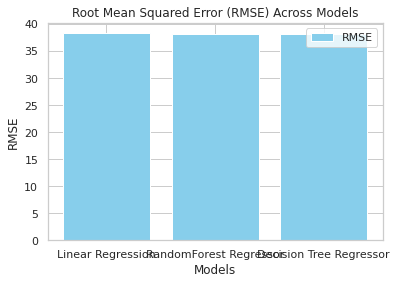

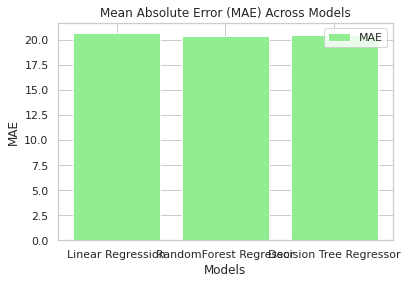

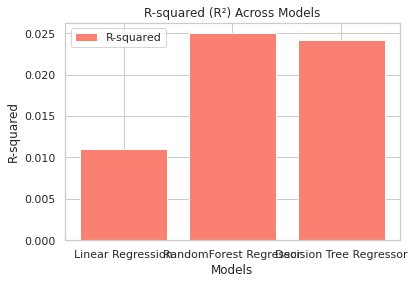

In [0]:
import matplotlib.pyplot as plt

models = ["Linear Regression", "RandomForest Regressor", "Decision Tree Regressor"]
rmse_values = [38.32, 38.19, 38.22]  
mae_values = [20.67, 20.42, 20.48]  
r2_values = [0.011, 0.025, 0.0242]    

# Plotting RMSE
plt.bar(models, rmse_values, color='skyblue', label='RMSE')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Across Models')
plt.legend()
plt.show()

# Plotting MAE
plt.bar(models, mae_values, color='lightgreen', label='MAE')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) Across Models')
plt.legend()
plt.show()

# Plotting R-squared
plt.bar(models, r2_values, color='salmon', label='R-squared')
plt.xlabel('Models')
plt.ylabel('R-squared')
plt.title('R-squared (R²) Across Models')
plt.legend()
plt.show()


Here We have compared the root mean square error, Mean Absolute Error and R-squared Across all three models 
we can see that:-
Root Mean Squared Error (RMSE):
The RMSE plot shows that all three models have relatively similar RMSE values around 38. Lower RMSE values indicate better model performance, so based on this metric alone, the random forest performs slightly better.

Mean Absolute Error (MAE):
The MAE plot shows that all three models have similar MAE values around 20. Like RMSE, lower MAE values are better, and here too Random Forest Regressor performs slightly better.

R-squared (R^2):
The R^2 plot shows the R-squared values for the models. R-squared ranges from 0 to 1, with higher values indicating better model fit. In this case, the random forest Regressor model has the highest R^2 value, around 0.025 followed by the Decision Tree Regressor and then Linear regression model at the least.